# 3D classification example based on DenseNet

This tutorial shows an example of 3D classification task based on DenseNet and array format transforms.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_classification/torch/densenet_training_array.ipynb)

## Setup environment

In [ ]:
%pip install -q "monai[nibabel, tqdm]"

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, NiftiDataset
from monai.transforms import (
    AddChannel, 
    Compose, 
    RandRotate90, 
    Resize, 
    ScaleIntensity, 
    ToTensor,
    Randomizable,
    LoadImaged,
    ToTensord,
)

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 0.4.0
Numpy version: 1.19.1
Pytorch version: 1.7.0a0+7036e91
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.0.1
Tensorboard version: 1.15.0+nv
gdown version: 3.12.2
TorchVision version: 0.8.0a0
ITK version: 5.1.2
tqdm version: 4.54.1
lmdb version: 1.0.0
psutil version: 5.7.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/root/data/MONAI


In [3]:
class IXIDataset(Randomizable, CacheDataset):
    resource = "http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar"
    md5 = "34901a0593b41dd19c1a1f746eac2d58"

    def __init__(
        self,
        root_dir,
        section,
        transform,
        download=False,
        seed=0,
        val_frac=0.2,
        test_frac=0.2,
        cache_num=sys.maxsize,
        cache_rate=1.0,
        num_workers=0,
    ):
        if not os.path.isdir(root_dir):
            raise ValueError("Root directory root_dir must be a directory.")
        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.set_random_state(seed=seed)
        dataset_dir = os.path.join(root_dir, "ixi")
        tarfile_name = f"{dataset_dir}.tar"
        if download:
            download_and_extract(self.resource, tarfile_name, dataset_dir, self.md5)
        # as a quick demo, we just use 10 images to show
        
        
        
        self.datalist = [
            {"image": os.path.join(dataset_dir, "IXI314-IOP-0889-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI249-Guys-1072-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI609-HH-2600-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI173-HH-1590-T1.nii.gz"), "label": 1},
            {"image": os.path.join(dataset_dir, "IXI020-Guys-0700-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI342-Guys-0909-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI134-Guys-0780-T1.nii.gz"), "label": 0},
            {"image": os.path.join(dataset_dir, "IXI577-HH-2661-T1.nii.gz"), "label": 1},
            {"image": os.path.join(dataset_dir, "IXI066-Guys-0731-T1.nii.gz"), "label": 1},
            {"image": os.path.join(dataset_dir, "IXI130-HH-1528-T1.nii.gz"), "label": 0},
        ]
        data = self._generate_data_list()
        super().__init__(
            data, transform, cache_num=cache_num, cache_rate=cache_rate, num_workers=num_workers,
        )

    def randomize(self, data=None):
        self.rann = self.R.random()

    def _generate_data_list(self):
        data = list()
        for d in self.datalist:
            self.randomize()
            if self.section == "training":
                if self.rann < self.val_frac + self.test_frac:
                    continue
            elif self.section == "validation":
                if self.rann >= self.val_frac:
                    continue
            elif self.section == "test":
                if self.rann < self.val_frac or self.rann >= self.val_frac + self.test_frac:
                    continue
            else:
                raise ValueError(
                    f"Unsupported section: {self.section}, "
                    "available options are ['training', 'validation', 'test']."
                )
            data.append(d)
        return data

In [4]:
train_ds = IXIDataset(
    root_dir=root_dir,
    section="training",
    transform=Compose([LoadImaged("image"), ToTensord("image")]),
    download=True,
)

Verified 'ixi.tar', md5: 34901a0593b41dd19c1a1f746eac2d58.
file /root/data/MONAI/ixi.tar exists, skip downloading.
Verified 'ixi.tar', md5: 34901a0593b41dd19c1a1f746eac2d58.


Load and cache transformed data: 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


In [5]:
# IXI dataset as a demo, downloadable from https://brain-development.org/ixi-dataset/
images = [
    os.sep.join([root_dir, "ixi", "IXI314-IOP-0889-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI249-Guys-1072-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI609-HH-2600-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI173-HH-1590-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI020-Guys-0700-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI342-Guys-0909-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI134-Guys-0780-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI577-HH-2661-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI066-Guys-0731-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI130-HH-1528-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI607-Guys-1097-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI175-HH-1570-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI385-HH-2078-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI344-Guys-0905-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI409-Guys-0960-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI584-Guys-1129-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI253-HH-1694-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI092-HH-1436-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI574-IOP-1156-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI585-Guys-1130-T1.nii.gz"]),
]

# 2 binary labels for gender classification: man and woman
labels = np.array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=np.int64)

# Define transforms
train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), RandRotate90(), ToTensor()])
val_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), ToTensor()])

# Define nifti dataset, data loader
check_ds = NiftiDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label)

# create a training data loader
train_ds = NiftiDataset(image_files=images[:10], labels=labels[:10], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = NiftiDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

# Create DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
for epoch in range(5):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{5}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", metric, epoch + 1)
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

<class 'torch.Tensor'> torch.Size([2, 1, 96, 96, 96]) tensor([0, 0])
----------
epoch 1/5
1/5, train_loss: 0.6991
2/5, train_loss: 0.8175
3/5, train_loss: 1.1161
4/5, train_loss: 0.6984
5/5, train_loss: 1.1039
epoch 1 average loss: 0.8870
----------
epoch 2/5
1/5, train_loss: 0.6388
2/5, train_loss: 1.0904
3/5, train_loss: 0.6800
4/5, train_loss: 0.7991
5/5, train_loss: 1.0728
epoch 2 average loss: 0.8562
saved new best metric model
current epoch: 2 current accuracy: 0.4000 best accuracy: 0.4000 at epoch 2
----------
epoch 3/5
1/5, train_loss: 1.0701
2/5, train_loss: 0.8654
3/5, train_loss: 1.0491
4/5, train_loss: 0.4717
5/5, train_loss: 0.8688
epoch 3 average loss: 0.8650
----------
epoch 4/5
1/5, train_loss: 0.6492
2/5, train_loss: 0.5954
3/5, train_loss: 1.0179
4/5, train_loss: 0.9682
5/5, train_loss: 0.7066
epoch 4 average loss: 0.7875
current epoch: 4 current accuracy: 0.4000 best accuracy: 0.4000 at epoch 2
----------
epoch 5/5
1/5, train_loss: 0.4382
2/5, train_loss: 1.0216
3/5,

# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

#### Bounds
If we were to test the occlusion centred on all voxels in our image, we would have to do `torch.prod(im.shape) = 96^3 = ~1e6` predictions. We can use the bounding box to only to the estimations in a region of interest, for example over one slice.

To do this, we simply give the bounding box as `(minC,maxC,minD,maxD,minH,maxH,minW,maxW)`. We can use `-1` for any value to use its full extent (`0` and `im.shape-1` for min's and max's, respectively).

#### Output
The output image in this example will look fairly bad, since our network hasn't been trained for very long. Training for longer should improve the quality of the occlusion map.

In [6]:
# create a validation data loader
test_ds = NiftiDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)

def get_next_im():    
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)

def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [7]:
# Get a random image and its corresponding label
im, label = get_next_im()

100%|██████████| 9216/9216 [01:21<00:00, 113.49it/s]


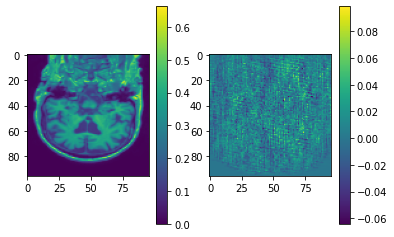

In [8]:
# Get the occlusion sensitivity map
from monai.metrics import compute_occlusion_sensitivity
# Only get a single slice to save time. 
# For the other dimensions (channel, width, height), use 
# -1 to use 0 and im.shape[x]-1 for min and max, respectively
depth_slice = im.shape[2]//2
bounds=[-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

heatmap = compute_occlusion_sensitivity(model, im, label, margin=10, n_batch=10, b_box=bounds)
plot_occlusion_heatmap(im[..., depth_slice,:,:], heatmap)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)